In [137]:
# OPTIONAL: Load the "autoreload" eX_orig[alias]tension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [138]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as hc
from src.config import get_experiment_artifacts
from src.go_util import get_ensembl_mappings

df = pd.read_excel("{}/outliers.xlsx".format(get_experiment_artifacts()))
df.head()

,GO,NS,enrichment,name,ratio_in_study,ratio_in_pop,p_uncorrected,depth,study_count,p_fdr_bh,study_items
0,GO:0006281,BP,e,DNA repair,65/496,361/18027,1.879901e-34,7,65,2.374879e-30,"11920, 12021, 12189, 12572, 13006, 13194, 1408..."
1,GO:0006364,BP,e,rRNA processing,37/496,120/18027,7.313208e-29,9,37,4.619388e-25,"12181, 19989, 20085, 27993, 52513, 52530, 5270..."
2,GO:0006974,BP,e,cellular response to DNA damage stimulus,64/496,487/18027,8.000393e-26,4,64,3.368965e-22,"11920, 12021, 12189, 12572, 13006, 13194, 1408..."
3,GO:0042254,BP,e,ribosome biogenesis,29/496,89/18027,1.210733e-23,5,29,3.823797e-20,"12181, 22596, 27993, 52513, 52530, 52705, 5341..."
4,GO:0006397,BP,e,mRNA processing,41/496,324/18027,2.972480e-16,8,41,7.510267e-13,"14105, 15387, 16588, 17149, 20638, 20901, 2268..."


In [139]:
final_genes = pd.read_csv("../outlier_detection/artifacts/final_gene_list.tsv", sep="\t", usecols=[0, 6], skiprows=1)[1:].rename(columns={"Measure": "Gene"})
final_genes.head()

,Gene,Pseudo-control
1,Atp6v1g1,False
2,H2ac18,False
3,Metap2,False
4,Xrcc5,False
5,H2ax,False


In [140]:
outliers = final_genes.iloc[:500, 0]
outliers.head()

1    Atp6v1g1
2      H2ac18
3      Metap2
4       Xrcc5
5        H2ax
Name: Gene, dtype: object

In [141]:
psuedo_controls = final_genes[final_genes["Pseudo-control"]]["Gene"]
psuedo_controls.head()

17935    Mob3b
17937    Htra4
17948     Ngfr
17950     Dmkn
17963    Trpc6
Name: Gene, dtype: object

In [142]:
all_genes = final_genes["Gene"]
all_genes.head()

1    Atp6v1g1
2      H2ac18
3      Metap2
4       Xrcc5
5        H2ax
Name: Gene, dtype: object

In [143]:
df_out = df[["name", "NS", "study_items"]]
df_out = df_out[df_out["NS"] == "MF"]
dummy_MF_df = pd.Series(dict(zip(df_out["name"], df_out["study_items"].str.replace(" ", "").str.split(",")))).str.join('|').str.get_dummies()
print(dummy_MF_df.shape)
dummy_MF_df.iloc[:5, :5]

(37, 252)


,100088,100210,102462,104806,105148
RNA binding,0,0,1,0,0
DNA-directed 5'-3' RNA polymerase activity,0,0,0,0,0
structural constituent of ribosome,0,0,0,0,0
nucleic acid binding,0,0,0,0,0
snoRNA binding,0,0,1,0,0


In [144]:
df_out = df[["name", "NS", "study_items"]]
df_out = df_out[df_out["NS"] == "BP"]
dummy_BP_df = pd.Series(dict(zip(df_out["name"], df_out["study_items"].str.replace(" ", "").str.split(",")))).str.join('|').str.get_dummies()
print(dummy_BP_df.shape)
dummy_BP_df.iloc[:5, :5]

(68, 274)


,100039801,100088,100608,102462,104806
DNA repair,0,0,0,0,1
rRNA processing,0,0,0,1,0
cellular response to DNA damage stimulus,0,0,0,0,1
ribosome biogenesis,0,0,1,1,0
mRNA processing,0,0,0,0,0


In [145]:
mappings = get_ensembl_mappings()
geneid2symbol = {}
for g in all_genes:
    if g in mappings:
        try:
            geneid2symbol[str(mappings[g]['entrezgene_id'])] = g
        except:
            continue

repair_genes = []
for geneid in dummy_BP_df.columns:
    if geneid in geneid2symbol:
        repair_genes.append(geneid2symbol[geneid])
len(repair_genes)

dummy_BP_df.columns = repair_genes
dummy_BP_df.head()

,Cldn24,Rcc1,Noc4l,Imp3,Fancm,Iars,Mtbp,Psmg2,Otub1,Fam111a,...,Wdr82,Polq,Trappc6b,Dbr1,Setdb1,Ube2n,Mrpl16,Cpsf1,Qars,Nat10
DNA repair,0,0,0,0,1,0,0,0,1,1,...,0,1,0,0,0,1,0,0,0,0
rRNA processing,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
cellular response to DNA damage stimulus,0,0,0,0,1,0,0,0,1,1,...,0,1,0,0,0,1,0,0,0,0
ribosome biogenesis,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
mRNA processing,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0


In [146]:
repair_genes = []
for geneid in dummy_MF_df.columns:
    if geneid in geneid2symbol:
        repair_genes.append(geneid2symbol[geneid])
len(repair_genes)

dummy_MF_df.columns = repair_genes
dummy_MF_df.head()

,Rcc1,Gpn2,Imp3,Fancm,Iars,Otub1,Fam111a,Eprs,Atad3a,Srsf1,...,Ddx52,Nlrp4c,Gtf2a1,Setdb1,Ube2n,Mrpl16,Cpsf1,Qars,Nat10,Taf13
RNA binding,0,0,1,0,0,0,0,1,0,1,...,1,0,0,0,0,0,1,1,0,0
DNA-directed 5'-3' RNA polymerase activity,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
structural constituent of ribosome,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
nucleic acid binding,0,0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0
snoRNA binding,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


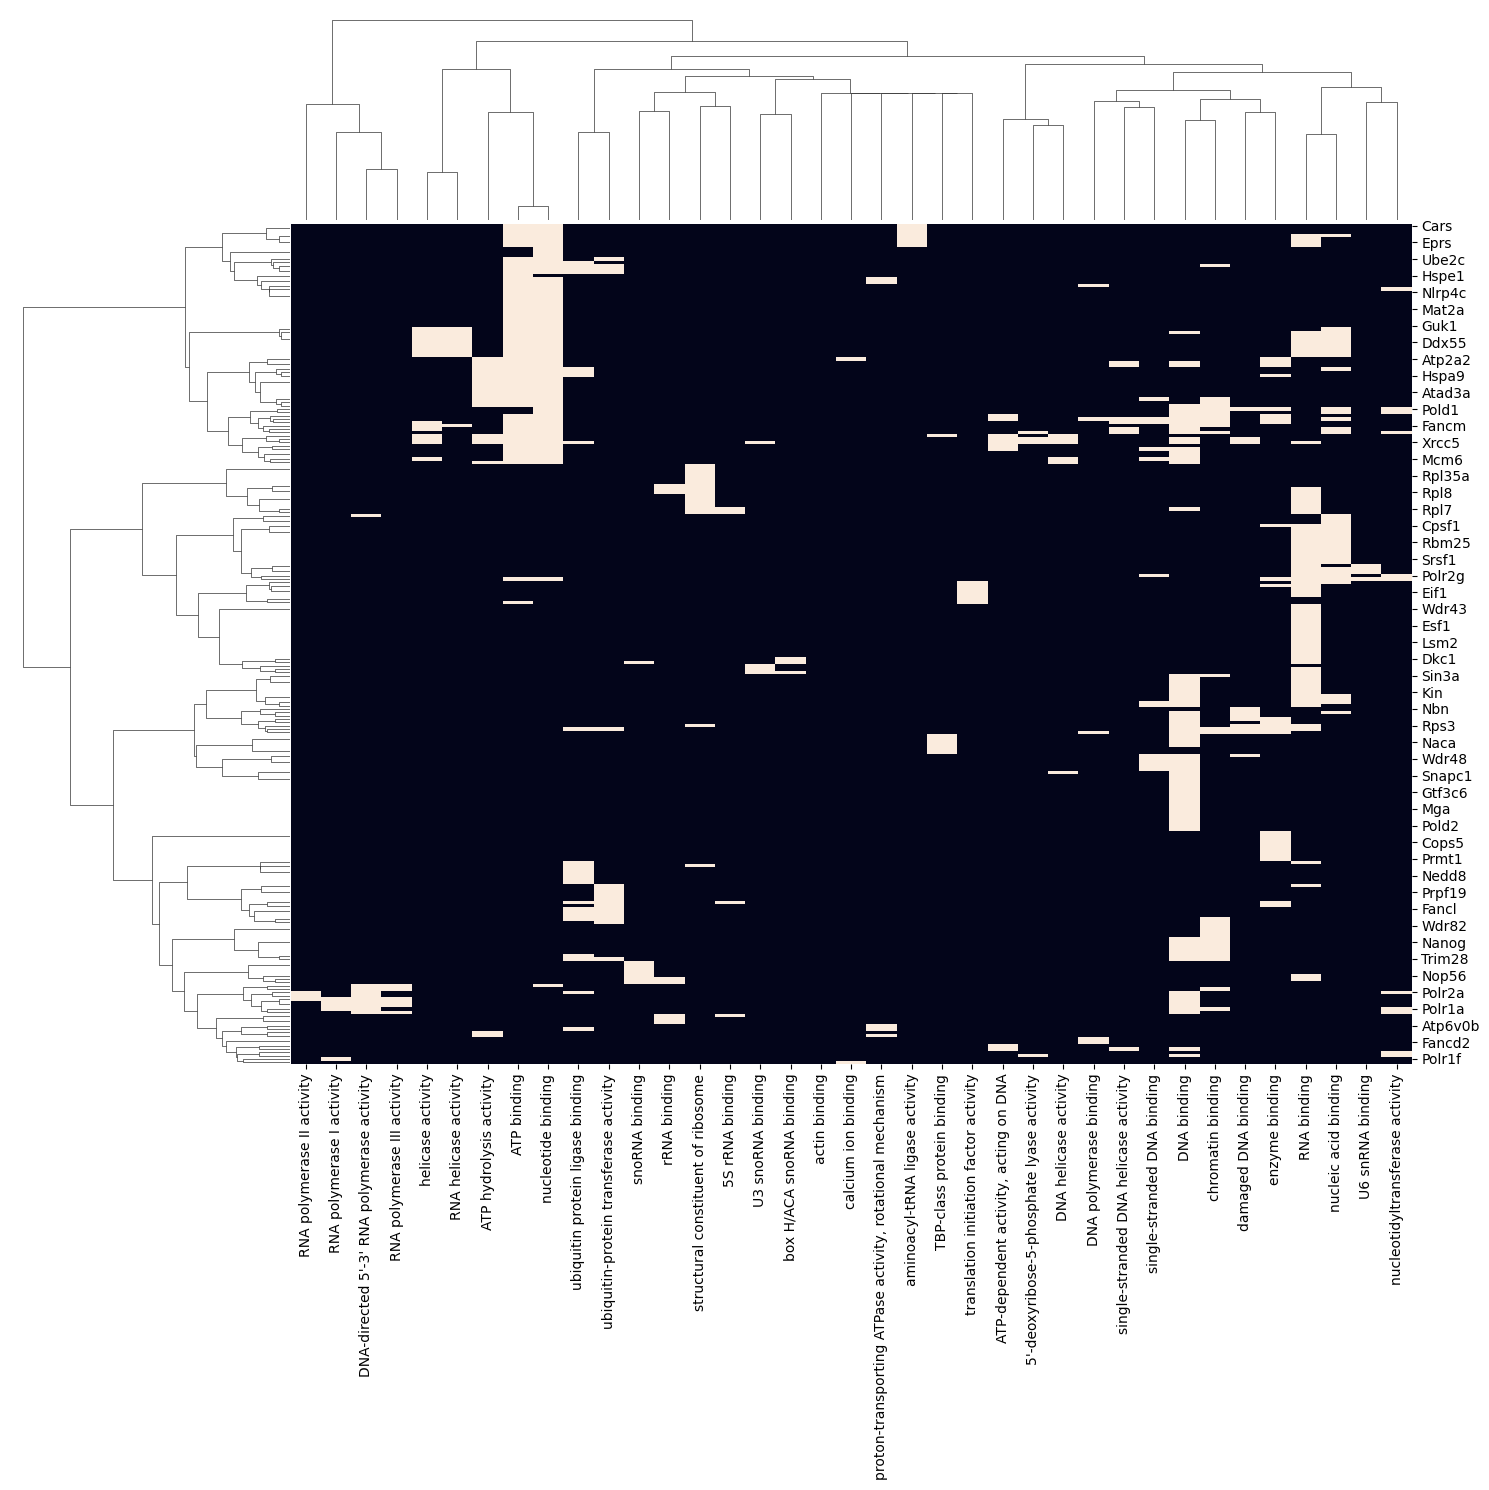

In [147]:
cm = sns.clustermap(dummy_MF_df.T, figsize=(15, 15), method="ward", metric="jaccard")
cm.cax.set_visible(False)

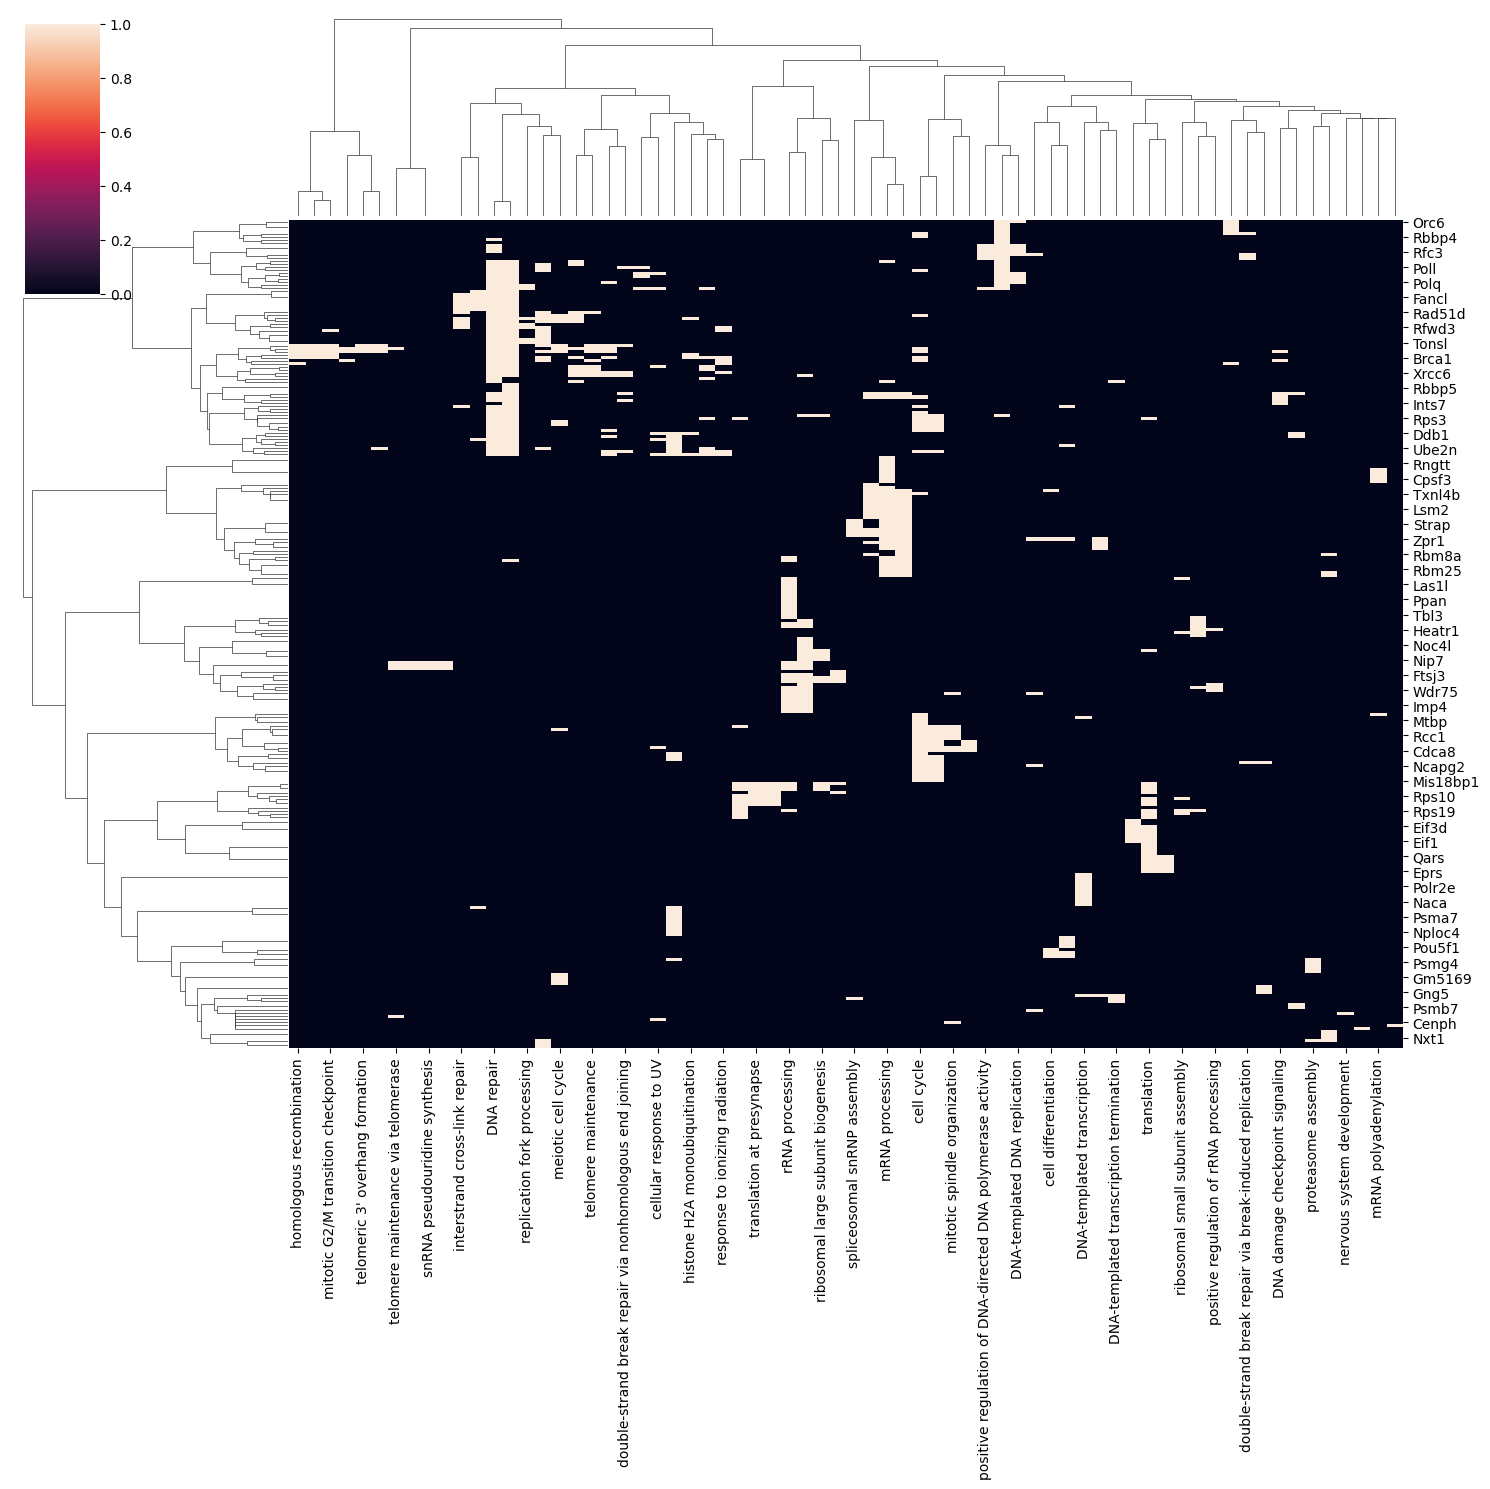

In [148]:
sns.clustermap(dummy_BP_df.T, figsize=(15, 15), method="ward", metric="jaccard")

In [149]:
print(dummy_BP_df.sum(axis=1).sort_values(ascending=False).head())

DNA repair                                  65
cellular response to DNA damage stimulus    64
cell cycle                                  42
mRNA processing                             41
rRNA processing                             37
dtype: int64


In [150]:
dT1 = pd.read_csv("../outlier_detection/artifacts/final_paired_replicate_mutational_profile_T1.tsv", sep="\t")
dT1 = dT1.set_index("Gene")
dT1.head()

dT2 = pd.read_csv("../outlier_detection/artifacts/final_paired_replicate_mutational_profile_T2.tsv", sep="\t")
dT2 = dT2.set_index("Gene")
dT2.head()

dT3 = pd.read_csv("../outlier_detection/artifacts/final_paired_replicate_mutational_profile_T3.tsv", sep="\t")
dT3 = dT3.set_index("Gene")
dT3.head()

,Deletion 0bp microhomology,Deletion 1bp microhomology,Deletion 2bp microhomology,Deletion with insertion,Homology Directed Repair,Any Insertion,Deletion 3+bp microhomology
Gene,,,,,,,
0610009B22Rik,0.080885,0.190840,0.181551,0.105939,0.162444,0.245307,0.033033
0610010K14Rik,0.072189,0.194623,0.173455,0.098725,0.148338,0.275665,0.037006
0610030E20Rik,0.071534,0.187883,0.197255,0.095467,0.141313,0.264316,0.042232
0610040J01Rik,0.055905,0.176345,0.188622,0.100737,0.149485,0.298484,0.030423
1110004F10Rik,0.067297,0.184216,0.188678,0.086940,0.154360,0.266092,0.052417


In [151]:
d = pd.concat({
    # "T1": dT1,
    "T2": dT2,
    "T3": dT3,
}, axis=1).dropna()
d.head()

T2                             \
              Deletion 0bp microhomology Deletion 1bp microhomology   
Gene                                                                  
0610009B22Rik                   0.060822                   0.194063   
0610010K14Rik                   0.069111                   0.197386   
0610030E20Rik                   0.060981                   0.214651   
0610040J01Rik                   0.068050                   0.188705   
1110004F10Rik                   0.056240                   0.212240   

                                                                  \
              Deletion 2bp microhomology Deletion with insertion   
Gene                                                               
0610009B22Rik                   0.258281                0.130756   
0610010K14Rik                   0.254420                0.136851   
0610030E20Rik                   0.245834                0.142445   
0610040J01Rik                   0.266137                0.123149   
1110004F10Rik                   0.234876                0.140256   

                                                      \
              Homology Directed Repair Any Insertion   
Gene                                                   
0610009B22Rik                 0.176772      0.077415   
0610010K14Rik                 0.164657      0.072453   
0610030E20Rik                 0.164248      0.070597   
0610040J01Rik                 0.177802      0.070914   
1110004F10Rik                 0.166542      0.077830   

                                                                  T3  \
              Deletion 3+bp microhomology Deletion 0bp microhomology   
Gene                                                                   
0610009B22Rik                    0.101890                   0.080885   
0610010K14Rik                    0.105123                   0.072189   
0610030E20Rik                    0.101245                   0.071534   
0610040J01Rik                    0.105243                   0.055905   
1110004F10Rik                    0.112016                   0.067297   

                                                                     \
              Deletion 1bp microhomology Deletion 2bp microhomology   
Gene                                                                  
0610009B22Rik                   0.190840                   0.181551   
0610010K14Rik                   0.194623                   0.173455   
0610030E20Rik                   0.187883                   0.197255   
0610040J01Rik                   0.176345                   0.188622   
1110004F10Rik                   0.184216                   0.188678   

                                                                              \
              Deletion with insertion Homology Directed Repair Any Insertion   
Gene                                                                           
0610009B22Rik                0.105939                 0.162444      0.245307   
0610010K14Rik                0.098725                 0.148338      0.275665   
0610030E20Rik                0.095467                 0.141313      0.264316   
0610040J01Rik                0.100737                 0.149485      0.298484   
1110004F10Rik                0.086940                 0.154360      0.266092   

                                           
              Deletion 3+bp microhomology  
Gene                                       
0610009B22Rik                    0.033033  
0610010K14Rik                    0.037006  
0610030E20Rik                    0.042232  
0610040J01Rik                    0.030423  
1110004F10Rik                    0.052417

In [152]:
Xpseudo = d.loc[psuedo_controls]
Xpseudo_gmean = pd.DataFrame(Xpseudo.groupby(level=0, axis=1).apply(stats.gmean).values.tolist(), index=["T2", "T3"], columns=d["T2"].columns)
Xpseudo_gmean = Xpseudo_gmean.div(Xpseudo_gmean.sum(axis=1), axis=0).stack()
Xpseudo_gmean

Xout = d.loc[d.index.isin(outliers)]
Xout

Xdiff = Xout - Xpseudo_gmean
Xdiff

row_linkage = hc.linkage(Xdiff, method="average", metric="correlation")
col_linkage = hc.linkage(Xdiff.T, method="average", metric="correlation")

cg = sns.clustermap(Xdiff,
    col_linkage=col_linkage,
    row_linkage=row_linkage,
    figsize=(10,
    100),
    center=0,
    dendrogram_ratio=(.25,
    .01),
    cmap="RdBu",
    cbar_pos=(0, .9, .001, .01), \
    robust=True)
cg.ax_heatmap.yaxis.tick_left()
cg.ax_heatmap.xaxis.tick_top()

pal = sns.color_palette('Dark2', Xdiff["T2"].columns.unique().shape[0])
lut = dict(zip(Xdiff["T2"].columns.unique(), pal))
col_colors = Xdiff["T2"].columns.to_series().map(lut)

for i, tick_label in enumerate(cg.ax_heatmap.axes.get_yticklabels()):
    tick_text = tick_label.get_text()
    # tick_label.set_color(row_colors[tick_text])
    tick_label.set_rotation(0)

for i, tick_label in enumerate(cg.ax_heatmap.axes.get_xticklabels()):
    tick_text = tick_label.get_text().split("-")[1]
    tick_label.set_color(lut[tick_text])
    tick_label.set_rotation(45)
    tick_label.set_ha("left")
plt.tight_layout()
plt.savefig("artifacts/hierarchical_clustering_T2T3.pdf")
plt.close()
print("Plot saved.")

outlier_sig_go_BP_terms = (pd.DataFrame(np.zeros((Xdiff.shape[0], dummy_BP_df.shape[0])), index=Xdiff.index, columns=dummy_BP_df.index) + dummy_BP_df.T).fillna(0)

col_linkage = hc.linkage(outlier_sig_go_BP_terms.loc[Xdiff.index].T, method="average", metric="jaccard")
cg = sns.clustermap(outlier_sig_go_BP_terms.loc[Xdiff.index],
    col_linkage=col_linkage,
    row_linkage=row_linkage,
    figsize=(20,
    100),
    center=0,
    dendrogram_ratio=(.25,
    .01),
    cmap="RdBu",
    cbar_pos=(0, .9, .001, .01), \
    robust=True)
cg.ax_heatmap.yaxis.tick_left()
cg.ax_heatmap.xaxis.tick_top()

for i, tick_label in enumerate(cg.ax_heatmap.axes.get_xticklabels()):
    tick_label.set_rotation(75)
    tick_label.set_ha("left")

plt.title("GO BP Terms vs Gene Mutational Profile Hierarchy")
plt.tight_layout()
plt.savefig("artifacts/hierarchical_clustering_T2T3_GO_BP.pdf")
plt.close()
print("Plot saved.")


outlier_sig_go_MF_terms = (pd.DataFrame(np.zeros((Xdiff.shape[0], dummy_MF_df.shape[0])), index=Xdiff.index, columns=dummy_MF_df.index) + dummy_MF_df.T).fillna(0)

col_linkage = hc.linkage(outlier_sig_go_MF_terms.loc[Xdiff.index].T, method="average", metric="jaccard")
cg = sns.clustermap(outlier_sig_go_MF_terms.loc[Xdiff.index],
    col_linkage=col_linkage,
    row_linkage=row_linkage,
    figsize=(20,
    100),
    center=0,
    dendrogram_ratio=(.25,
    .01),
    cmap="RdBu",
    cbar_pos=(0, .9, .001, .01), \
    robust=True)
cg.ax_heatmap.yaxis.tick_left()
cg.ax_heatmap.xaxis.tick_top()

for i, tick_label in enumerate(cg.ax_heatmap.axes.get_xticklabels()):
    tick_label.set_rotation(75)
    tick_label.set_ha("left")
plt.title("GO MF Terms vs Gene Mutational Profile Hierarchy")
plt.tight_layout()
plt.savefig("artifacts/hierarchical_clustering_T2T3_GO_MF.pdf")
plt.close()
print("Plot saved.")

Plot saved.
Plot saved.
Plot saved.


In [174]:
outlier_sig_go_BP_terms.loc["Slc25a5"][outlier_sig_go_BP_terms.loc["Slc25a5"].astype(bool)]

transmembrane transport    1.0
Name: Slc25a5, dtype: float64

In [175]:
outlier_sig_go_MF_terms.loc["Slc25a5"][outlier_sig_go_MF_terms.loc["Slc25a5"].astype(bool)]

ubiquitin protein ligase binding    1.0
Name: Slc25a5, dtype: float64